In [ ]:
import h5py
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#PCP EXTRACTED PROPERTIES FOR UNIPROT PROTEINS
json_path = "/content/drive/MyDrive/protein_props.json"
with open(json_path) as f:
  data = json.load(f)

okk = pd.read_json(json_path)
properties = okk.transpose()

druggable_data = "/content/drive/MyDrive/druggable_proteins.txt"
with open(druggable_data) as f:
  druggable_proteins = [line.strip() for line in f]
print(len(druggable_proteins))

approved_drugs = "/content/drive/MyDrive/approved_druggable_proteins.txt"
with open(approved_drugs) as g:
  approved_proteins = [line.strip() for line in g]
print(len(approved_proteins))

is_druggable = []
for i in properties.index:
  if i in druggable_proteins:
    is_druggable.append(1)
  else:
    is_druggable.append(0)

approved_drugs = []
for j in properties.index:
  if j in approved_proteins:
    approved_drugs.append(1)
  else:
    approved_drugs.append(0)

properties['is_druggable'] = is_druggable
properties['is_approved'] = approved_drugs

PCP_Properties = properties.copy()

index = 'ACDEFGHIKLMNPQRSTVWY'
amino_acid_percent = {}
for i in index:
  amino_acid_percent[i] = []
for j in PCP_Properties['Amino Acid Percent']:
  for ind in index:
    amino_acid_percent[ind].append(j[ind])
for okk in index:
  PCP_Properties = pd.concat([PCP_Properties, pd.Series(amino_acid_percent[okk], index = PCP_Properties.index, name = f"Amino Acid Percent {okk}")], axis = 1)

PCP_Properties[f"Molar Extinction Coefficient 1"] = pd.Series([x[0] for x in PCP_Properties['Molar Extinction Coefficient']], index = PCP_Properties.index)
PCP_Properties[f"Molar Extinction Coefficient 2"] = pd.Series([x[1] for x in PCP_Properties['Molar Extinction Coefficient']], index = PCP_Properties.index)

PCP_Properties[f"Secondary Structure helix"] = pd.Series([x[0] for x in PCP_Properties['Secondary Structure']], index = PCP_Properties.index)
PCP_Properties[f"Secondary Structure turn"] = pd.Series([x[1] for x in PCP_Properties['Secondary Structure']], index = PCP_Properties.index)
PCP_Properties[f"Secondary Structure sheet"] = pd.Series([x[2] for x in PCP_Properties['Secondary Structure']], index = PCP_Properties.index)

PCP_Properties.drop(columns = ['Amino Acid Count','Amino Acid Percent',"Molar Extinction Coefficient","Flexibility","Secondary Structure",'Sequence'], inplace = True)
PCP_Properties['Sequence Length'] = PCP_Properties['Sequence Length'] .astype(int)
PCP_Properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']] = PCP_Properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']].astype(float)

3345
2652


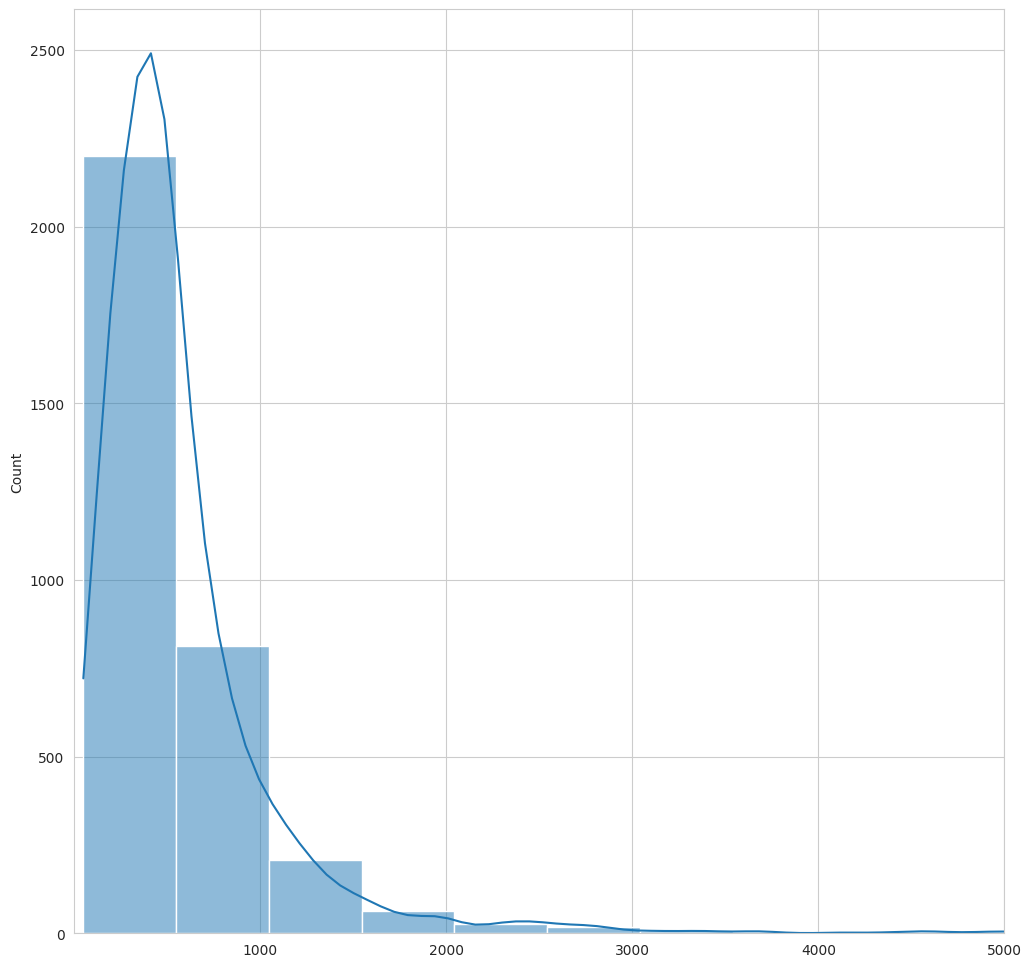

In [ ]:
#Sequence number plotting
sequence = properties['Sequence']
non_druggable_sequence = properties[properties['is_druggable'] == 1]['Sequence']

length = []
for i in non_druggable_sequence:
  length.append(len(i))

fig,ax = plt.subplots(figsize = (12,12))
sns.histplot(length, kde = True, ax = ax, binwidth = 500)
ax.set_xlim(1,5000)
plt.show()

In [ ]:
#Non duggable clustering using CD-HIT Algorithm
non_druggable_sequence_data = {}
for i in properties[properties['is_druggable'] == 0].index:
  non_druggable_sequence_data[i] = properties.loc[i]['Sequence']

#Sequence info in fasta format for CD-HIT Tool
with open('proteins.fasta', 'w') as f:
    for idx, seq in non_druggable_sequence_data.items():
        f.write(f'>{idx}\n')
        f.write(f'{seq}\n')

#CD HIT TOOL SERVER : https://galaxy.pasteur.fr/tool_runner?tool_id=toolshed.pasteur.fr/repos/afelten/microbiome_analyses/CD-HIT/4.6.1
cluster_output = "/content/drive/MyDrive/BDDF_Research/Galaxy14-[CD-HIT_on_data_13__cluster.list].txt"

def extract_representative_proteins(cluster_file):
    representative_proteins = []

    with open(cluster_file, 'r') as file:
        for line in file:
            if line.startswith('>Cluster'):
                continue  # Skip cluster headers
            elif line.endswith('*\n'):  # Representative protein line
                protein_id = line.split('>')[1].split('...')[0]
                representative_proteins.append(protein_id)

    return representative_proteins

clustered_non_druggable_proteins = extract_representative_proteins(cluster_output)

In [ ]:
#Group Amino Acid Composition Encodings data
gdpc_encodings = "/content/drive/MyDrive/BDDF_Research/gdpc_encodings.json"

# Read the JSON file
with open(gdpc_encodings, 'r') as file:
    data = json.load(file)

# Create a DataFrame from the JSON data
gpdc_encodings = pd.DataFrame(data).transpose()

In [ ]:
#autoencoder embeddings latent values
latent_path = "/content/drive/MyDrive/BDDF_Research/latent_values.csv"
latent_data = pd.read_csv(latent_path).transpose()
latent_data.columns = [f"Latent_Value_{i}" for i in latent_data.columns]

#glycolisation data
glycolisation_path = "/content/drive/MyDrive/glycosylation.csv"
glycolisation = pd.read_csv(glycolisation_path)
glycolisation.index = glycolisation['Unnamed: 0']
glycolisation.drop(columns = ['Unnamed: 0'], inplace = True)

#Post-Translational Modification data
ptm_path = "/content/drive/MyDrive/PTM_counts.csv"
ptm = pd.read_csv(ptm_path)
ptm.index = ptm["Unnamed: 0"]
ptm.drop(columns = ['Unnamed: 0'], inplace = True)

#protein-protein interaction data
ppi_path = "/content/drive/MyDrive/ppi.json"
ppi = pd.read_json(ppi_path)
ppi = ppi.transpose()

In [ ]:
o = final_data.dropna()
print(o.isna().sum().sum())

0

In [ ]:
from sklearn.decomposition import PCA

# subcellular data
location_path = "/content/drive/MyDrive/subcellular_locations2.json"
with open(location_path, 'r') as file:
    data = json.load(file)

unique_groups = set()

for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry:
                unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)
# Initialize a list to collect the data
rows = []

for protein_id in PCP_Properties.index:
    row = {group: 0 for group in unique_groups_list}
    if protein_id in data:
        for entry in data[protein_id].get("general", []):
            if "group" in entry and entry["group"] in unique_groups:
                row[entry["group"]] = 1
    row["protein_id"] = protein_id
    rows.append(row)

# Create the DataFrame
subcellular_data = pd.DataFrame(rows).set_index("protein_id")

#reduction of sparsity from 97.38% to 0% using PCA Reduction
model = PCA(n_components = 35, random_state = 123)
pca_output = model.fit_transform(subcellular_data)
subcellular_pca_reduced_data = pd.DataFrame(pca_output, columns = [f"Location {i}" for i in range(35)])
subcellular_pca_reduced_data.index = PCP_Properties.index

In [ ]:
#check sparsity in dataframe
def sparsity(okk):
    counter = 0
    for i in okk.to_numpy():
      for j in i:
        if(j == 0):
          counter +=1
    return(counter/(okk.to_numpy().shape[0]*(okk.to_numpy().shape[1])))

print(f"Sparsity of ppi : {sparsity(ppi)*100}")
print(f"Sparsity of ptm : {sparsity(ptm)*100}")
print(f"Sparsity of subcellular data : {sparsity(subcellular_data)*100}")
print(f"Sparsity of subcellular_pc_reduced_data  : {sparsity(subcellular_pca_reduced_data)*100}")

Sparsity of ppi : 67.68620925907801
Sparsity of ptm : 77.28198101203876
Sparsity of subcellular data : 97.38504453362043
Sparsity of subcellular_pc_reduced_data  : 0.0


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class create_model(nn.Module):
  def __init__(self, hidden_size, num_hidden_layers):
    super(create_model, self).__init__()
    self.fc1 = nn.LazyLinear(hidden_size)
    self.relu = nn.ReLU()
    # num_hidden_layers of linear and relu
    self.hidden_layers = nn.ModuleList([nn.LazyLinear(hidden_size) for _ in range(num_hidden_layers)])
    self.hidden_relus = nn.ModuleList([nn.ReLU() for _ in range(num_hidden_layers)])
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    for layer, relu in zip(self.hidden_layers, self.hidden_relus):
      x = layer(x)
      x = relu(x)
    x = self.dropout(x)
    return x

pcp_model = create_model(16,2)
gpdc_model = create_model(16,2)
glyco_model = create_model(5,2)
ppi_model = create_model(4,2)
ptm_model = create_model(4,2)
subcell_model = create_model(16,2)

class Dataset_prep(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

class ModularNetwork(nn.Module):
    def __init__(self, module_list, input_splits):
        super(ModularNetwork, self).__init__()
        self.modules_list = nn.ModuleList(module_list)
        self.input_splits = input_splits
        self.final_layers = nn.Sequential(
            # nn.LazyLinear(64),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.LazyLinear(32),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            nn.LazyLinear(16),
            nn.ReLU(),
            nn.LazyLinear(1),  # Assuming binary classification with a single output neuron
            nn.Sigmoid()  # For binary classification output
        )

    def forward(self, inputs):
        split_inputs = torch.split(inputs, self.input_splits, dim=1)
        module_outputs = [module(x) for module, x in zip(self.modules_list, split_inputs)]
        combined_output = torch.cat(module_outputs, dim=1)
        final_output = self.final_layers(combined_output)
        return final_output

# Initialize modular network with all individual models
module_list = [pcp_model, gpdc_model, glyco_model, ppi_model, ptm_model, subcell_model]
input_splits = [PCP_Properties.shape[1] -2, gpdc_encodings.shape[1], glycolisation.shape[1],
                ptm.shape[1], ppi.shape[1], subcellular_data.shape[1]]  # Update with actual number of features in each part
modular_network = ModularNetwork(module_list, input_splits)
print(input_splits)

#for splitting of data
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

def data_splitting(x_sample, y_sample):
  druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
  non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

  druggable_X = x_sample[druggable_indices]
  druggable_y = y_sample[druggable_indices]

  non_druggable_X = x_sample[non_druggable_indices]
  non_druggable_y = y_sample[non_druggable_indices]

  class_size = 1000
  druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=123)
  non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size= 2*class_size, random_state=123)

  X_test = pd.concat((druggable_X_test, non_druggable_X_test))
  y_test = pd.concat((druggable_y_test, non_druggable_y_test))

  X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
  y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))

  # Shuffle the training and testing data
  X_train, y_train = shuffle(X_train, y_train, random_state=123)
  X_test, y_test = shuffle(X_test, y_test, random_state=123)

  #scaling of data
  sc = StandardScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.fit_transform(X_test)
  ada = ADASYN(random_state=42)

  X_train, y_train = ada.fit_resample(X_train, y_train)
  return X_train, X_test, y_train, y_test



[32, 25, 6, 5, 4, 50]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:


def train(train_loader, test_loader, model, learning_rate, num_epochs, test_loss_step):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  train_loss = []
  test_loss = []
  best_train_loss = 1e10
  best_test_loss = 1e10
  best_train_model = None
  best_test_model = None


  for i in range(num_epochs):
    model.train()
    losses = 0
    for inputs,labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs.float())
      loss = criterion(outputs.squeeze(), labels.float())
      loss.backward()
      optimizer.step()
      losses += loss.item()

    train_losses = losses/len(train_loader)
    print(f"Epochs {i+1}/{num_epochs} : train_loss = {train_losses}")
    train_loss.append(train_losses)
    if train_losses < best_train_loss:
      best_train_loss = train_losses
      best_train_model = model

    if(i%test_loss_step == 0):
      model.eval()
      test_losses = 0
      correct = 0
      total = 0
      for inputs,labels in test_loader:
        outputs = model(inputs.float())
        loss = criterion(outputs.squeeze(), labels.float())
        test_losses += loss.item()
        predictions = (outputs.squeeze() > 0.5).long()
        correct += (predictions == labels).sum().item()
        total += labels.shape[0]

      accuracy = 100*(correct/total)
      test_loss_k = test_losses/len(test_loader)
      print(f'***Epoch [{i+1}/{num_epochs}], Test Loss: {test_loss_k:.4f}, Accuracy: {accuracy:.2f}%')
      test_loss.append(test_loss_k)
      if test_loss_k < best_test_loss:
        best_test_loss = test_loss_k
        best_test_model = model

  return train_loss, test_loss, best_train_model, best_test_model

In [ ]:
# final_data = pd.concat([PCP_Properties, gpdc_encodings, glycolisation, ptm, ppi, subcellular_pca_reduced_data], axis = 1)
final_data = pd.concat([PCP_Properties, gpdc_encodings, glycolisation, ptm, ppi, subcellular_data, latent_data], axis = 1).dropna()
X_train, X_test, y_train, y_test = data_splitting(final_data.drop(columns = ['is_approved','is_druggable']), final_data['is_druggable'])
train_loader = DataLoader(Dataset_prep(X_train, y_train), batch_size=512, shuffle=True)
test_loader = DataLoader(Dataset_prep(X_test, y_test), batch_size=512, shuffle=False)

In [ ]:
# Train the modular network
learning_rate = 0.001
num_epochs = 50
test_loss_step = 1
train_loss, test_loss, best_train_model, best_test_model = train(train_loader, test_loader, modular_network, learning_rate, num_epochs, test_loss_step)

Epochs 1/50 : train_loss = 0.6799830753924483
***Epoch [1/50], Test Loss: 0.6284, Accuracy: 68.73%
Epochs 2/50 : train_loss = 0.5973633477243326
***Epoch [2/50], Test Loss: 0.5555, Accuracy: 71.70%
Epochs 3/50 : train_loss = 0.5433958460718898
***Epoch [3/50], Test Loss: 0.5356, Accuracy: 73.87%
Epochs 4/50 : train_loss = 0.5122475033089265
***Epoch [4/50], Test Loss: 0.5296, Accuracy: 74.70%
Epochs 5/50 : train_loss = 0.4932616297471321
***Epoch [5/50], Test Loss: 0.5334, Accuracy: 74.30%
Epochs 6/50 : train_loss = 0.47972290697744335
***Epoch [6/50], Test Loss: 0.5314, Accuracy: 75.00%
Epochs 7/50 : train_loss = 0.46747308666423215
***Epoch [7/50], Test Loss: 0.5376, Accuracy: 74.47%
Epochs 8/50 : train_loss = 0.458211119902336
***Epoch [8/50], Test Loss: 0.5421, Accuracy: 74.17%
Epochs 9/50 : train_loss = 0.4460823551072913
***Epoch [9/50], Test Loss: 0.5405, Accuracy: 74.73%
Epochs 10/50 : train_loss = 0.4368943415455899
***Epoch [10/50], Test Loss: 0.5487, Accuracy: 74.37%
Epochs 

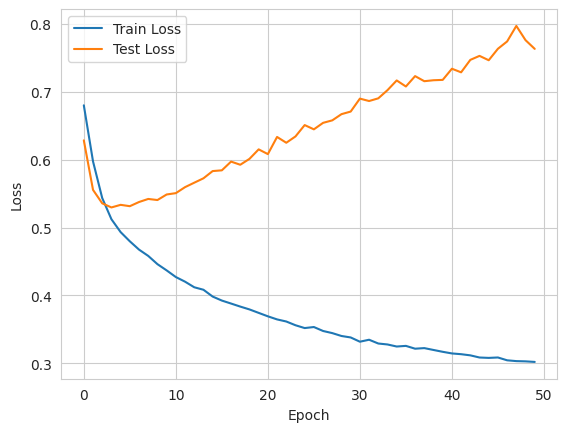

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50
931/931 [==============================] - 14s 11ms/step - loss: 4.2361 - accuracy: 0.6393 - val_loss: 1.8098 - val_accuracy: 0.6120
Epoch 2/50
931/931 [==============================] - 8s 9ms/step - loss: 1.0849 - accuracy: 0.7408 - val_loss: 0.8057 - val_accuracy: 0.7127
Epoch 3/50
931/931 [==============================] - 11s 12ms/step - loss: 0.6960 - accuracy: 0.7545 - val_loss: 0.7083 - val_accuracy: 0.7193
Epoch 4/50
931/931 [==============================] - 10s 11ms/step - loss: 0.6512 - accuracy: 0.7659 - val_loss: 0.7532 - val_accuracy: 0.7173
Epoch 5/50
931/931 [==============================] - 8s 9ms/step - loss: 0.6466 - accuracy: 0.7755 - val_loss: 0.7276 - val_accuracy: 0.7237
Epoch 6/50
931/931 [==============================] - 10s 11ms/step - loss: 0.6339 - accuracy: 0.7819 - val_loss: 0.7247 - val_accuracy: 0.7247
Epoch 7/50
931/931 [==============================] - 9s 10ms/step - loss: 0.6295 - accuracy: 0.7850 - val_loss: 0.7661 - val_accuracy: 0.71

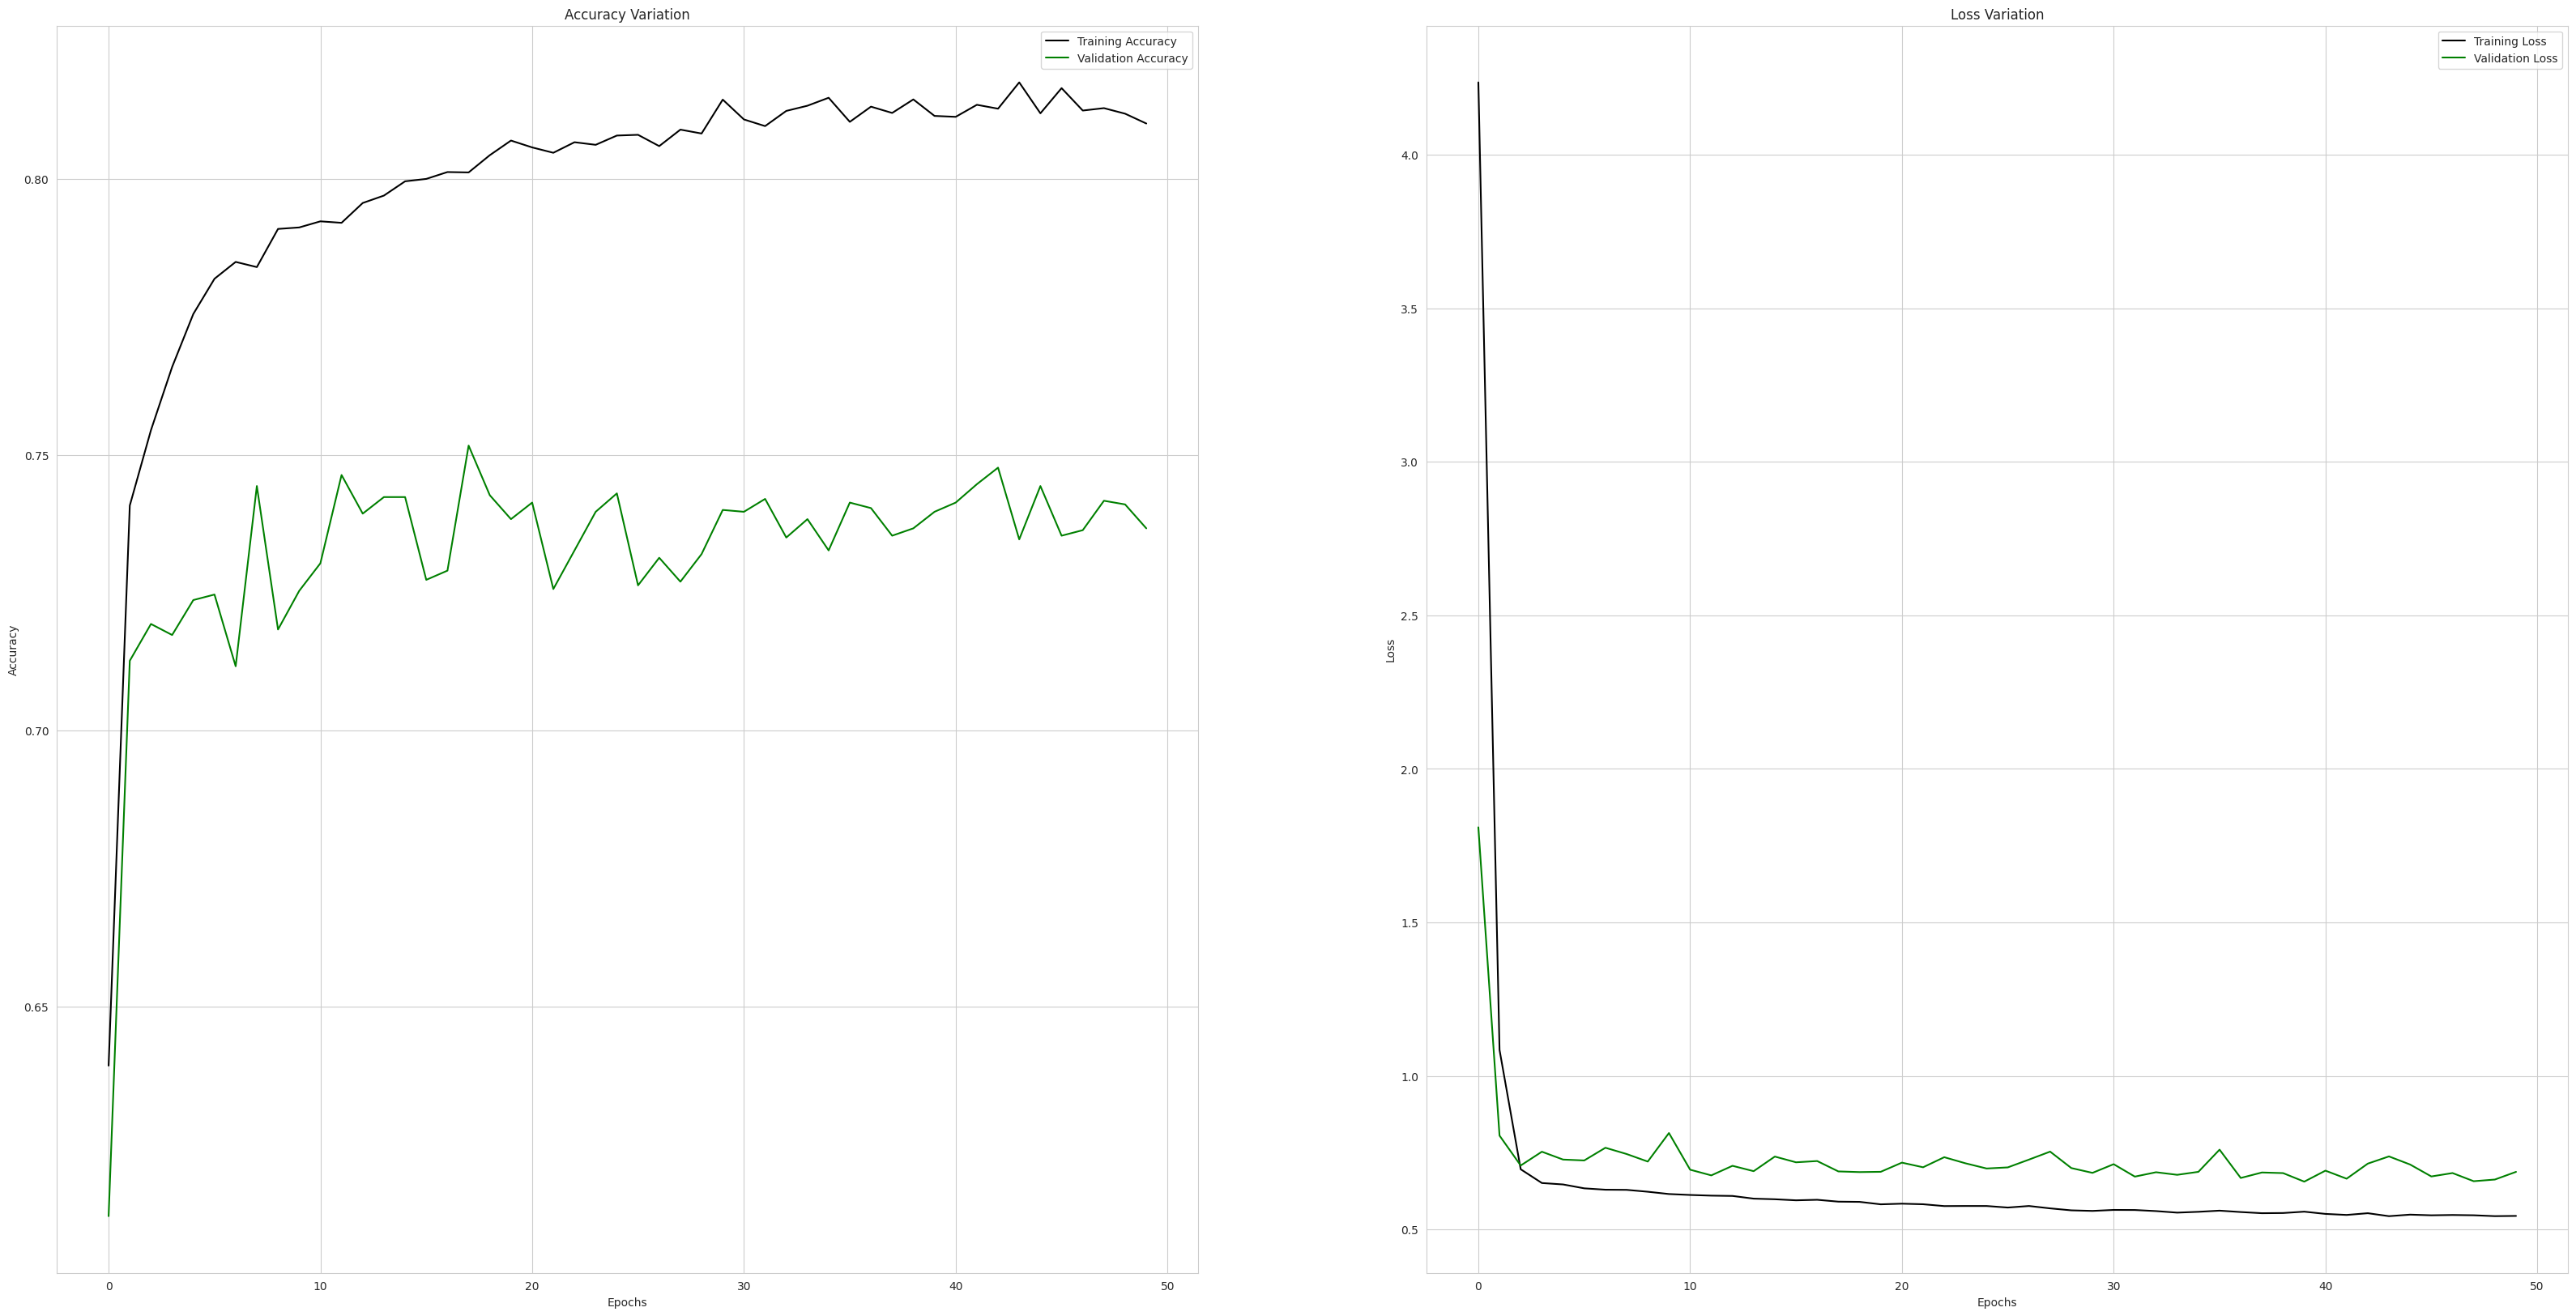

In [ ]:
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sktime.classification.sklearn import RotationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score

def test_results(model, k):
  results = {}
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
  okk = cross_validate(model, X_test, y_test, cv=k, scoring=scoring)

  for metric in scoring:
    mean_score = np.mean(okk['test_' + metric])
    results[metric] = mean_score

  return results

#using xgboost boosting algorithms
model_1 = xgboost.XGBClassifier()
model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
metrics_1 = test_results(model_1, 5)

#using logistic regression algorithm
model_2 = LogisticRegression(max_iter = 1000)
model_2.fit(X_train,y_train)
y_pred_2 = model_2.predict(X_test)
metrics_2= test_results(model_2, 5)

#using svm(optional takes long training time)
#using SVM algorithm using various kernels
model_3 = svm.SVC(kernel = 'linear',probability = True)
model_4 = svm.SVC(kernel = 'poly',probability = True)
model_5 = svm.SVC(kernel = 'rbf',probability = True)

model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)
model_5.fit(X_train,y_train)

y_pred_3 = model_3.predict(X_test)
metrics_3= test_results(model_3, 5)

y_pred_4 = model_4.predict(X_test)
metrics_4= test_results(model_4, 5)

y_pred_5 = model_3.predict(X_test)
metrics_5 = test_results(model_5, 5)

#using RandomForest with estimator = 1500 which is no of trees employed
model_6 = RandomForestClassifier(n_estimators = 1500, criterion = 'entropy', random_state = 42)
model_6.fit(X_train,y_train)
y_pred_6 = model_6.predict(X_test)
metrics_6= test_results(model_6, 5)

#using Rotation Forest with estimators = 1500
model_7 = RotationForest(n_estimators=1500)
model_7.fit(X_train,y_train)
y_pred_7 = model_7.predict(X_test)
metrics_7= test_results(model_7, 5)

#elastic net(optional not much promising metrics)
from sklearn.linear_model import SGDClassifier
model_8 = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.5, l1_ratio=0.5)
model_8.fit(X_train, y_train)

# using ANN for classification

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

model_7 = tf.keras.Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.15),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_7.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)
y_pred_7 = model_7.predict(X_test)
y_pred_7 = (y_pred_7 >= 0.5).astype(int)
metrics_7 = {
  'accuracy' : accuracy_score(y_test,y_pred_7),
  'precision_weighted' : precision_score(y_test,y_pred_7,average = 'weighted'),
  'recall_weighted' : recall_score(y_test,y_pred_7,average = 'weighted'),
  'f1_weighted' : f1_score(y_test,y_pred_7,average = 'weighted'),
}
print(metrics_7)

fig,ax = plt.subplots(figsize = (40,20), ncols = 2)
ax[0].plot(history.history['accuracy'],color = 'black', label = 'Training Accuracy')
ax[0].plot(history.history['val_accuracy'],color = 'green', label = 'Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Accuracy Variation')
ax[0].legend()

ax[1].plot(history.history['loss'],color = 'black', label = 'Training Loss')
ax[1].plot(history.history['val_loss'],color = 'green', label = 'Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Loss Variation')
ax[1].legend()
plt.show()

In [ ]:
from sktime.classification.sklearn import RotationForest

#using Rotation Forest with estimators = 1500
model_9 = RotationForest(n_estimators=1500)
model_9.fit(X_train,y_train)
y_pred_9 = model_8.predict(X_test)
metrics_9= test_results(model_9, 5)

In [ ]:
model_list = {
    "XGBoost" : pd.Series(metrics_1),
    "Logistic_Regression" : pd.Series(metrics_2),
    "SVM_Linear" : pd.Series(metrics_3),
    "SVM_Polynomial" : pd.Series(metrics_4),
    "SVM_RBF" : pd.Series(metrics_5),
    "Random_Forest" : pd.Series(metrics_6),
    "ANN" : pd.Series(metrics_7),
    "SGD_Elastic_Net" : pd.Series(metrics_8),
    "Rotation_Forest" : pd.Series(metrics_9),
}
results = pd.DataFrame(model_list).T
print(results)

,accuracy,precision_weighted,recall_weighted,f1_weighted
XGBoost,0.742333,0.732507,0.742333,0.732169
Logistic_Regression,0.711333,0.695777,0.711333,0.694848
Random_Forest,0.741667,0.735111,0.741667,0.717015
ANN,0.736667,0.728851,0.736667,0.730843


In [ ]:
#roc-auc curve for various algorithm
fpr_1, tpr_1, _ = roc_curve(y_test, model_1.predict_proba(X_test)[:, 1])
fpr_2, tpr_2, _ = roc_curve(y_test, model_2.predict_proba(X_test)[:, 1])
fpr_3, tpr_3, _ = roc_curve(y_test, model_3.predict_proba(X_test)[:, 1])
fpr_4, tpr_4, _ = roc_curve(y_test, model_4.predict_proba(X_test)[:, 1])
fpr_5, tpr_5, _ = roc_curve(y_test, model_5.predict_proba(X_test)[:, 1])
fpr_6, tpr_6, _ = roc_curve(y_test, model_6.predict_proba(X_test)[:, 1])
fpr_8, tpr_8, _ = roc_curve(y_test, model_8.predict_proba(X_test)[:, 1])
fpr_9, tpr_9, _ = roc_curve(y_test, model_9.predict_proba(X_test)[:, 1])

from sklearn.metrics import roc_auc_score

auc_1 = roc_auc_score(y_test, model_1.predict_proba(X_test)[:, 1])
auc_2 = roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1])
auc_3 = roc_auc_score(y_test, model_3.predict_proba(X_test)[:, 1])
auc_4 = roc_auc_score(y_test, model_4.predict_proba(X_test)[:, 1])
auc_5 = roc_auc_score(y_test, model_5.predict_proba(X_test)[:, 1])
auc_6 = roc_auc_score(y_test, model_6.predict_proba(X_test)[:, 1])
auc_8 = roc_auc_score(y_test, model_8.predict_proba(X_test)[:, 1])
auc_9 = roc_auc_score(y_test, model_9.predict_proba(X_test)[:, 1])

# Plot ROC curves for each model with AUC values in the legend
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label=f'XGBoost (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot(fpr_3, tpr_3, label=f'SVM_Linear (AUC = {auc_3:.2f})')
plt.plot(fpr_4, tpr_4, label=f'SVM_Polynomial (AUC = {auc_4:.2f})')
plt.plot(fpr_5, tpr_5, label=f'SVM_RBF (AUC = {auc_5:.2f})')
plt.plot(fpr_6, tpr_6, label=f'Random Forest (AUC = {auc_6:.2f})')
plt.plot(fpr_8, tpr_8, label=f'SGD_ElasticNet (AUC = {auc_8:.2f})')
plt.plot(fpr_9, tpr_9, label=f'Rotation Forest (AUC = {auc_9:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend()
plt.show()

In [ ]:
#feature importance report
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
random_forest_list = okk[:40]
plt.figure(figsize=(18, 20))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

In [ ]:
#feature importance report
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
random_forest_list = okk[:40]
plt.figure(figsize=(18, 20))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

In [ ]:
#feature importance report
feature_importance = model_1.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
random_forest_list = okk[:40]
plt.figure(figsize=(18, 20))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from XgBoost")
plt.show()

In [ ]:
##Feature Selection Script not included ******